# Libraries

In [ ]:
import pandas as pd
import numpy as np
import string 
import re
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from yellowbrick.cluster.elbow import kelbow_visualizer
from kmeanstf import KMeansTF
from scipy.spatial.distance import cdist
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

#-- Sklearn Package
from sklearn.feature_extraction.text import CountVectorizer      #-- Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer      #-- Tf-Idf
from sklearn.decomposition import PCA                            #-- PCA
from sklearn.decomposition import TruncatedSVD                   #-- SVD
from sklearn.svm import SVC                                      #-- SVM
from sklearn.model_selection import train_test_split             #-- Split Dataset
from sklearn.metrics import classification_report                #-- Model Summary 
from sklearn.cluster import KMeans                               #-- K-means Algorithm
from sklearn.metrics import confusion_matrix                     #-- Confusion Matrix                             
from sklearn.cluster import AgglomerativeClustering              #-- Hierarchical
from sklearn.neighbors import KNeighborsClassifier               #-- knn
from sklearn.preprocessing import StandardScaler                 #-- Standard
from xgboost import XGBClassifier                                #-- XGBoost
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

In [ ]:
# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
reviews = pd.read_csv('/content/gdrive/MyDrive/Reviews.csv',
                      sep = ",")

In [ ]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [ ]:
print(reviews.shape)
print(reviews.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [ ]:
 # Remove duplicates
 data = reviews.drop_duplicates(subset = {"UserId",
                                          "ProfileName",
                                          "Time",
                                          "Text"})

In [ ]:
print('Original dataframe rows: ' + str(reviews.shape[0]) + '\n' +
      'New dataframe rows: ' + str(data.shape[0]) + '\n' +
      'Num duplicates: ' + str(reviews.shape[0]-data.shape[0]))

Original dataframe rows: 568454
New dataframe rows: 393933
Num duplicates: 174521


# Explorative Analysis

In [ ]:
data['Length'] = data['Text'].str.len()
length_grp = data.groupby('Score')['Length'].mean()
score_grp = data.groupby('Score')['Length'].count()
col = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

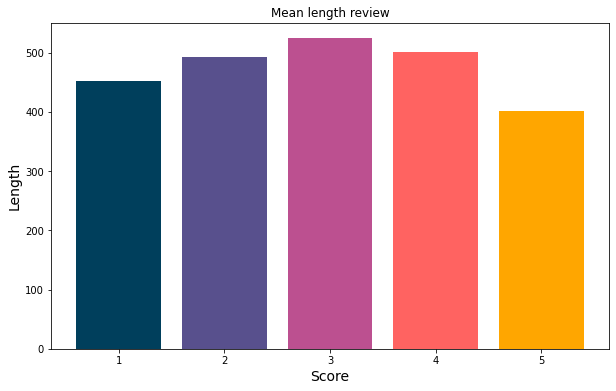

In [ ]:
# Mean length review plot
plt.figure(figsize = (10, 6))
plt.bar(['1','2','3','4','5'], 
        length_grp,
        color = col)
plt.xlabel("Score", size = 14)
plt.ylabel("Length", size = 14)
plt.title('Mean length review')
plt.show()

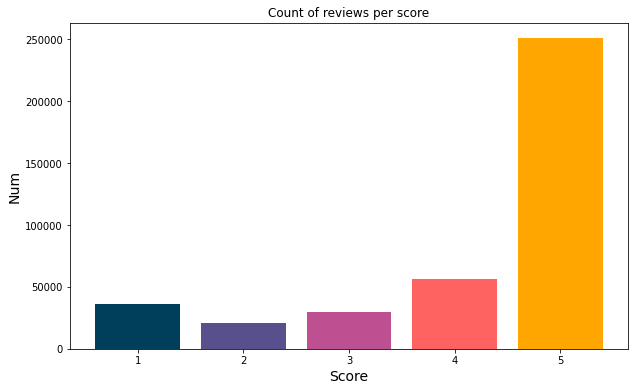

In [ ]:
# Count of reviews per score plot
plt.figure(figsize = (10, 6))
plt.bar(['1','2','3','4','5'], 
        score_grp,
        color = col)
plt.xlabel("Score", size = 14)
plt.ylabel("Num", size = 14)
plt.title('Count of reviews per score')
plt.show()

# Data pre-processing

## Data balancing

In [ ]:
# Finding the minimum between class frequency
score_grp.min() 

20802

In [ ]:
# Random Under Sampling (RUS)
data_bal = (data.groupby('Score', as_index = False).apply(lambda x: x.sample(n = score_grp.min())).reset_index(drop = True))

In [ ]:
print('Before sampling: ' + str(data.shape[0]) + ' obs\n' +
      'After sampling: ' + str(data_bal.shape[0]) + ' obs')

Before sampling: 393933 obs
After samplinh: 104010 obs


In [ ]:
length_grp_bal = data_bal.groupby('Score')['Length'].mean()
score_grp_bal = data_bal.groupby('Score')['Length'].count()

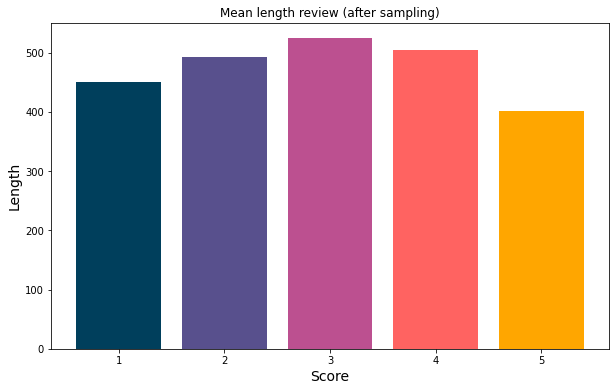

In [ ]:
# Mean length review (after sampling) plot
plt.figure(figsize = (10, 6))
plt.bar(['1','2','3','4','5'], 
        length_grp_bal,
        color = col)
plt.xlabel("Score", size = 14)
plt.ylabel("Length", size = 14)
plt.title('Mean length review (after sampling)')
plt.show()

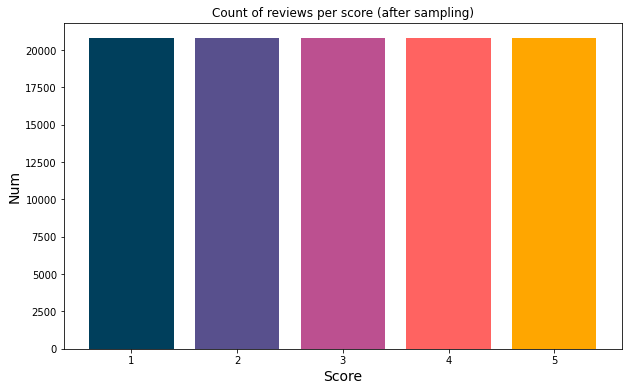

In [ ]:
# Count of reviews per score (after sampling) plot
plt.figure(figsize = (10, 6))
plt.bar(['1','2','3','4','5'], 
        score_grp_bal,
        color = col)
plt.xlabel("Score", size = 14)
plt.ylabel("Num", size = 14)
plt.title('Count of reviews per score (after sampling)')
plt.show()

In [ ]:
# Final data frame
score = data_bal['Score']
text_tot = data_bal['Text']

# Text pre-processing



*   Lower Case
*   Decontraction phrases
*   Remove URLS
*   Remove punctuation
*   Remove numbers
*   Remove blankspace
*   Tokenization
*   Remove Stopwords
*   Lemmatization
*   Stemming



In [ ]:
def preprocessing(doc_text):
    tokenized = []                                                   #-- List for Tokenization
    tokenized_no_stopwords = []                                      #-- List for Tokenization not a Stopword
    lemmed = []                                                      #-- List of Lemmatized Words
    stemmed = []                                                     #-- List of Stemmed Words
    
    doc_text = doc_text.str.lower()                                  #-- Lower Case

    for phrase in doc_text:
        phrase = re.sub(r"won't", "will not", phrase)                #-- Decontract phrase
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)

        phrase = re.sub(r"http\S+", '', phrase)                      #-- Remove URLS

        phrase = phrase.translate(str.maketrans('', '',
                                                string.punctuation)) #-- Remove Punctuation
        phrase = re.sub("\S*\d\S*", "", phrase).strip()              #-- Remove words with number
        phrase = re.sub(r'\d+', '', phrase)                          #-- Remove Blankspace

        phrase = WordPunctTokenizer().tokenize(phrase)               #-- Tokenization
        tokenized.append(phrase)                                     #-- Add to Tokenization List
    
    stop = nltk.corpus.stopwords.words('english')                    #-- Remove stopwords
    
    for phrase in tokenized:
        temp = []                                                    #-- Temporary File for a Single Sentence
        for token in phrase:
            if token not in stop:                                    #-- If the Token is a Stopword
                temp.append(token)                                   #-- Add to Temp List
        tokenized_no_stopwords.append(temp)                          #-- Otherwise is not a Stopword
            
    #-- Stemming and Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    for phrase in tokenized_no_stopwords:
        temp_stem = []
        temp_lem = []

        for word in phrase:
            temp_stem.append(stemmer.stem(word))
            temp_lem.append(lemmatizer.lemmatize(word))
        stemmed.append(temp_stem)
        lemmed.append(temp_lem)
    
    return (stemmed,                                                  #-- Stemmed List
            lemmed)                                                   #-- Lemmed List

In [ ]:
text = preprocessing(doc_text = text_tot)


In [ ]:
text_stemmed = text[0]
text_lemmed = text[1]

In [ ]:
print(text_stemmed[0],'\n', text_lemmed[0])

['price', 'insan', 'dollar', 'equat', 'kool', 'aid', 'sugar', 'bed', 'bath', 'beyond', 'carri'] 
 ['price', 'insane', 'dollar', 'equates', 'kool', 'aid', 'sugar', 'bed', 'bath', 'beyond', 'carry']


# Text representation

*   Tf-Idf
*   Bag of Words


In [ ]:
# From token to phrase function
def token_to_phrase(token_list):
    phrase_list = []
    
    for phrase in token_list:
        seq = ""
        for word in phrase:
            seq = seq + " " + word                                              #-- Add a Blankspace
        phrase_list.append(seq)                                                 #-- Attach each Token in a Phrase
    return phrase_list

In [ ]:
text_stemmed_preprocessed = token_to_phrase(token_list = text_stemmed)
text_lemmed_preprocessed  = token_to_phrase(token_list = text_lemmed)

## Tf-Idf

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),                                 #-- Uni-grams and Bi-grams
                             max_features = 30000)                              #-- Most 30000 frequent grams across the text
X_text_stemmed_tfidf = vectorizer.fit_transform(text_stemmed_preprocessed)
X_text_lemmed_tfidf = vectorizer.fit_transform(text_lemmed_preprocessed)

In [ ]:
print(X_text_stemmed_tfidf.get_shape())
print(X_text_lemmed_tfidf.get_shape())

(104010, 69079)
(104010, 67154)


## Bag of Words

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,2),                                 #-- Uni-grams and Bi-grams
                             max_features = 30000)                              #-- Most 30000 frequent grams across the text
X_text_stemmed_bow =  vectorizer.fit_transform(text_stemmed_preprocessed)
X_text_lemmed_bow = vectorizer.fit_transform(text_lemmed_preprocessed)

In [ ]:
print(X_text_stemmed_bow.get_shape())
print(X_text_lemmed_bow.get_shape())

## Saving results

In [ ]:
dataset_list = [X_text_stemmed_bow, X_text_stemmed_tfidf,
                X_text_lemmed_bow, X_text_lemmed_tfidf]

with open('lista_dataset.pkl', 'wb') as f:
  pickle.dump(dataset_list, f)

!cp lista_dataset.pkl '/content/gdrive/MyDrive/lista_dataset.pkl'

In [ ]:
with open('lista_dataset.pkl', 'rb') as f:
    dataset_list = pickle.load(f)

X_text_stemmed_bow = dataset_list[0]
X_text_stemmed_tfidf = dataset_list[1]
X_text_lemmed_bow = dataset_list[2]
X_text_lemmed_tfidf = dataset_list[3]

# Dimensionality reduction: SVD

In [ ]:
def svd(data, n_comp):
  svd = TruncatedSVD(n_components = n_comp,                                     #-- Number of components
                     n_iter = 100)                                              #-- Number of iterations
  temp = svd.fit_transform(data)                                                #-- Apply SVD to Dataset
  print('Explained variance ratio: ', sum(svd.explained_variance_ratio_))
  return temp

In [ ]:
stemmed_bow_svd = svd(X_text_stemmed_bow, 
                      n_comp = 300)                                             #-- Dimensionality of output data

Explained variance ratio:  0.5356130463630753


In [ ]:
lemmed_bow_svd = svd(X_text_lemmed_bow, 
                     n_comp = 300)                                              #-- Dimensionality of output data

In [ ]:
stemmed_tfidf_svd = svd(X_text_stemmed_tfidf, 
                        n_comp = 300)                                           #-- Dimensionality of output data

Explained variance ratio:  0.22822353090804812


In [ ]:
lemmed_tfidf_svd = svd(X_text_lemmed_tfidf, 
                       n_comp = 300)                                            #-- Dimensionality of output data

## Saving Results

In [ ]:
svd_list = [stemmed_bow_svd, stemmed_tfidf_svd,
       lemmed_bow_svd, lemmed_tfidf_svd]

with open('svd_dec_red.pkl', 'wb') as f:
  pickle.dump(svd_list, f)

!cp svd_list.pkl '/content/gdrive/MyDrive/svd_dec_red.pkl'

In [ ]:
with open('svd_dec_red.pkl', 'rb') as f:
    svd_list = pickle.load(f)

stemmed_bow_svd = svd_list[0]
stemmed_tfidf_svd = svd_list[1]
lemmed_bow_svd = svd_list[2]
lemmed_tfidf_svd = svd_list[3]

# Text Classification

* XGBoost
* SVM
* KNN



## Train - Test splitting

In [ ]:
# Stemmed BoW
X_trn_stem_bow, X_tst_stem_bow, y_trn, y_tst = train_test_split(stemmed_bow_svd,           #-- dataset
                                                                score,                     #-- class
                                                                test_size = 0.30,          #-- 30% test set
                                                                random_state = 123)
scalar = StandardScaler(with_mean=False)
X_trn_stem_bow_std = scalar.fit_transform(X_trn_stem_bow)
X_tst_stem_bow_std= scalar.transform(X_tst_stem_bow)

In [ ]:
# Lemmed BoW
X_trn_lem_bow, X_tst_lem_bow, y_trn, y_tst = train_test_split(lemmed_bow_svd,              #-- dataset
                                                              score,                       #-- class
                                                              test_size = 0.30,            #-- 30% test set
                                                              random_state = 123)
scalar = StandardScaler(with_mean=False)
X_trn_lem_bow_std = scalar.fit_transform(X_trn_lem_bow)
X_tst_lem_bow_std = scalar.transform(X_tst_lem_bow)

In [ ]:
# Stemmed Tf-Idf
X_trn_stem_tfidf, X_tst_stem_tfidf, y_trn, y_tst = train_test_split(stemmed_tfidf_svd,     #-- dataset
                                                                    score,                 #-- class
                                                                    test_size = 0.30,      #-- 30% test set
                                                                    random_state = 123)
scalar = StandardScaler(with_mean=False)
X_trn_stem_tfidf_std = scalar.fit_transform(X_trn_stem_tfidf)
X_tst_stem_tfidf_std= scalar.transform(X_tst_stem_tfidf)

In [ ]:
# Lemmed Tf-Idf
X_trn_lem_tfidf, X_tst_lem_tfidf, y_trn, y_tst = train_test_split(lemmed_bow_svd,         #-- dataset
                                                                  score,                  #-- class
                                                                  test_size = 0.30,       #-- 30% test set
                                                                  random_state = 123)
scalar = StandardScaler(with_mean=False)
X_trn_lem_tfidf_std = scalar.fit_transform(X_trn_lem_tfidf)
X_tst_lem_tfidf_std = scalar.transform(X_tst_lem_tfidf)

## XGBoost

### Stemmed BoW (with tuning)

In [ ]:
params_grid = {
    'gamma': [0, 1, 1.5],                                                       #-- default = 0
    'max_depth': [1,3,6]                                                        #-- default = 6
    }

XGB_clf = GridSearchCV(XGBClassifier(booster='gbtree'),                         #-- Classifier
                       params_grid, 
                       cv=3,                                                    #-- 3-fold cross validation
                       verbose = 3)
XGB_clf = XGB_clf.fit(X_trn_stem_bow_std, y_trn)                                #-- Fitting

print('Best hyperparameters:')
print(XGB_clf.best_params_)

In [ ]:
# Test
y_pred_stem_bow_XGB = XGB_clf.predict(X_tst_stem_bow_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_stem_bow_XGB))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_stem_bow_XGB)
print(cm)
ax = sns.heatmap(cm,cmap='Blues',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5']).set_ylim(5, 0)

### Lemmed BoW

In [ ]:
# Fitting
XGB_clf = XGBClassifier(booster='gbtree')                                       #-- Max_deph = 6, gamma = 0
XGB_clf_lem_bow = XGB_clf.fit(X_trn_lem_bow_std, y_trn)

# Test
y_pred_lem_bow_XGB = XGB_clf_lem_bow.predict(X_tst_lem_bow_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_lem_bow_XGB))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_lem_bow_XGB)
print(cm)
ax = sns.heatmap(cm,cmap='Blues',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5']).set_ylim(5, 0)

### Stemmed Tf-Idf

In [ ]:
# Fitting
XGB_clf_stem_tfidf = XGB_clf.fit(X_trn_stem_tfidf_std, y_trn)

# Test
y_pred_stem_tfidf_XGB = XGB_clf_stem_tfidf.predict(X_tst_stem_tfidf_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_stem_tfidf_XGB))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_stem_tfidf_XGB)
print(cm)
ax = sns.heatmap(cm,cmap='Blues',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5']).set_ylim(5, 0)

### Lemmed Tf-Idf

In [ ]:
# Fitting
XGB_clf_lem_tfidf = XGB_clf.fit(X_trn_lem_tfidf_std, y_trn)

# Test
y_pred_lem_tfidf_XGB = XGB_clf_lem_tfidf.predict(X_tst_lem_tfidf_std)

# Classificaiton report
print('Classification report:')
print(classification_report(y_tst, y_pred_lem_tfidf_XGB))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_lem_tfidf_XGB)
print(cm)
ax = sns.heatmap(cm,
                 cmap='Blues',
                 xticklabels=['1','2','3','4','5'],
                 yticklabels=['1','2','3','4','5']).set_ylim(5, 0)

## SVM

### Stemmed BoW (with tuning)

In [ ]:
param_grid = {'C': [1, 25, 50],                                                 #-- default = 1
              'gamma': ['scale','auto']                                         #-- default = 'scale'
              }

SVC_clf = GridSearchCV(SVC(kernel='rbf'),                                       #-- Classifier
                       param_grid, 
                       cv=3,                                                    #-- 3-fold cross validation
                       verbose = 3)
SVC_clf = SVC_clf.fit(X_trn_stem_bow_std, y_trn)                       #-- Fitting

print("Best parameters combination: \nC = {C} \ngamma = {gamma}".format(C = SVC_clf.best_estimator_.C, gamma = SVC_clf.best_estimator_.gamma))

In [ ]:
# Test
y_pred_stem_bow_SVC = SVC_clf.predict(X_tst_stem_bow_std)

# Classificaiton report
print('Classification report:')
print(classification_report(y_tst, y_pred_stem_bow_SVC))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_stem_bow_SVC)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

### Lemmed BoW

In [ ]:
# Fitting 
SVC_clf = SVC(kernel='rbf',C=1,gamma='auto')
SVC_clf_lem_bow = SVC_clf.fit(X_trn_lem_bow_std, y_trn)

# Test
y_pred_lem_bow_SVC = SVC_clf_lem_bow.predict(X_tst_lem_bow_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_lem_bow_SVC))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_lem_bow_SVC)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

### Stemmed Tf-Idf

In [ ]:
# Fitting
SVC_clf_stem_tfidf = SVC_clf.fit(X_trn_stem_tfidf_std, y_trn)

# Test 
y_pred_stem_tfidf_SVC = SVC_clf_stem_tfidf.predict(X_tst_stem_tfidf_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_stem_tfidf_SVC))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_stem_tfidf_SVC)
print(cm)
ax = sns.heatmap(cm,
                 cmap='Blues',
                 xticklabels=['1','2','3','4','5'],
                 yticklabels=['1','2','3','4','5']).set_ylim(5, 0)

### Lemmed Tf-Idf

In [ ]:
# Fitting
SVC_clf_lem_tfidf = SVC_clf.fit(X_trn_lemmed_tfidf_std, y_trn)   

# Test
y_pred_lem_tfidf_SVC = SVC_clf_lem_tfidf.predict(X_tst_lemmed_tfidf_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_lemmed_tfidf_SVC))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_lemmed_tfidf_SVC)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

## K-NN

### Stemmed BoW (with tuning)

In [ ]:
grid_params={
    'n_neighbors': list(range(5,51,5))                                          #-- default = 5
    }

KNN_clf = GridSearchCV(KNeighborsClassifier(),                                  #-- Classifier
                       grid_params,
                       cv = 3,                                                  #-- 3-fold cross validation
                       verbose = 3)

KNN_clf = KNN_clf.fit (X_trn_stem_bow_std, y_trn)                               #-- Fitting
print('Best k: ',KNN_clf.best_params_)

In [ ]:
# Test
y_pred_stem_bow_KNN = KNN_clf.predict(X_tst_stem_bow_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_stem_bow_KNN))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_stem_bow_KNN)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

### Lemmed BoW

In [ ]:
# Fitting
KNN_clf = KNeighborsClassifier(n_neighbors = 50)
KNN_clf_lem_bow = KNN_clf.fit(X_trn_lem_bow_std, y_trn)

# Test
y_pred_lem_bow_KNN = KNN_clf_lem_bow.predict(X_tst_lem_bow_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_lem_bow_KNN))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_lem_bow_KNN)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

### Stemmed Tf-Idf

In [ ]:
# Fitting
KNN_clf_stem_tfidf = KNN_clf.fit(X_trn_stem_tfidf_std, y_trn)

# Test
y_pred_stem_tfidf_KNN = KNN_clf.predict(X_tst_stem_tfidf_std)

# Classification report
print('Classification report:')
print(classification_report(y_tst, y_pred_stem_tfidf_KNN))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_stem_tfidf_KNN)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

### Lemmed Tf-Idf

In [ ]:
# Fitting
KNN_clf_lem_tfidf = KNN_clf.fit(X_trn_lemm_tfidf_std, y_trn)

# Test
y_pred_lemm_tfidf_KNN = KNN_clf.predict(X_tst_lemm_tfidf_std)

# Classificaiton report
print('Classification report:')
print(classification_report(y_tst, y_pred_lemm_tfidf_KNN))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_tst, y_pred_lemm_tfidf_KNN)
print(cm)
ax=sns.heatmap(cm,
               cmap='Blues',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)

# Text Clustering

## k-Means

In [ ]:
# Standardization of lemmed BoW data
scalar = StandardScaler(with_mean=False)            
X_lemmed_bow_scale = scalar.fit_transform(lemmed_bow_svd)

In [ ]:
# Function finding the best K considering silhouette 
kelbow_visualizer(KMeans(random_state=123, verbose=1),
                  X_lemmed_bow_scale, 
                  k=(2,11),                                                     # -- iterating k between 2 and 10 
                  metric='silhouette')

In [ ]:
#Function finding the best K through elbow method using distortion 
kelbow_visualizer(KMeans(random_state=123, verbose=1),
                  X_lemmed_bow_scale,
                  k=(2,11),                                                     # -- iterating k between 2 and 10 
                  metric='distortion')

In [ ]:
# Fitting k=5 (best k considering the elbow method)
kmeans5 = KMeansTF(n_clusters=5, random_state=123)

# Clustering
y_clust5= kmeans5.fit_predict(X_lemmed_bow_scale)

# Score against cluster plot
cluster_kmeans5 = kmeans5.labels_ + 1
clusters5 = cluster_kmeans5.numpy().tolist()
cm_kmeans5 = confusion_matrix(score, clusters5)
print(cm_kmeans5)
ax=sns.heatmap(cm_kmeans5,
               cmap='Oranges',
               xticklabels=["1","2","3","4","5"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)
plt.xlabel('Cluster k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)

In [ ]:
# t-SNE in 2 components for plotting clusters (k=5)
tsne = TSNE(verbose=1, perplexity=100, random_state=123)
X_embedded = tsne.fit_transform(X_lemmed_bow_scale)
sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(5, l=.4, s=.9)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=clusters5, legend='full', palette=palette)
plt.title('t-SNE with Kmeans k=5')
plt.show()

In [ ]:
# Fitting k=3 (best k considering silhouette)
kmeans3 = KMeansTF(n_clusters=3, random_state=123)

# Clustering
y_clust3= kmeans3.fit_predict(X_lemmed_bow_scale)

# Score against cluster plot
cluster_kmeans3 = kmeans3.labels_ + 1
clusters3 = cluster_kmeans3.numpy().tolist()
cm_kmeans3 = confusion_matrix(score, clusters3)
cm_kmeans3 = np.delete(cm_kmeans3, [3,4], 1)
print(cm_kmeans3)
ax=sns.heatmap(cm_kmeans3,
               cmap='Oranges',
               xticklabels=["1","2","3"],
               yticklabels=["1","2","3","4","5"]).set_ylim(5,0)
plt.xlabel('Cluster k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)

In [ ]:
# t-SNE in 2 components for plotting clusters (k=3)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=clusters3, legend='full', palette=palette)
plt.title('t-SNE with Kmeans k=3')
plt.show()

## Gerarchico Agglomerativo

Metrica: euclidea \\
Legame: singolo

In [ ]:
agglomerative = AgglomerativeClustering(distance_threshold = None,                    #-- Number Cluster to Find
                                        n_clusters = 5,                               #-- Number of Cluster
                                        affinity = 'euclidean',                       #-- Metric
                                        linkage = 'single').fit(svd_list_prova[0])    #-- Linkage
labels_agglomerative = agglomerative.labels_ + 1                                      #-- Cluster Label
print(confusion_matrix(score, labels_agglomerative))                                  #-- Confusion Matrix

Metrica: euclidea \\
Legame: completo

In [ ]:
agglomerative = AgglomerativeClustering(distance_threshold = None,                    #-- Number Cluster to Find
                                        n_clusters = 5,                               #-- Number of Cluster
                                        affinity = 'euclidean',                       #-- Metric
                                        linkage = 'complete').fit(svd_list_prova[0])  #-- Linkage
labels_agglomerative = agglomerative.labels_ + 1                                      #-- Cluster Label
print(confusion_matrix(score, labels_agglomerative))                                  #-- Confusion Matrix

Metrica: Manhattan \\
Legame: singolo

In [ ]:
agglomerative = AgglomerativeClustering(distance_threshold = None,                    #-- Number Cluster to Find
                                        n_clusters = 5,                               #-- Number of Cluster
                                        affinity = 'manhattan',                       #-- Metric
                                        linkage = 'single').fit(svd_list_prova[0])    #-- Linkage
labels_agglomerative = agglomerative.labels_ + 1                                      #-- Cluster Label
print(confusion_matrix(score, labels_agglomerative))                                  #-- Confusion Matrix

Metrica: Manhattan \\
Legame: completo

In [ ]:
agglomerative = AgglomerativeClustering(distance_threshold = None,                    #-- Number Cluster to Find
                                        n_clusters = 5,                               #-- Number of Cluster
                                        affinity = 'manhattan',                       #-- Metric
                                        linkage = 'complete').fit(svd_list_prova[0])  #-- Linkage
labels_agglomerative = agglomerative.labels_ + 1                                      #-- Cluster Label
print(confusion_matrix(score, labels_agglomerative))                                  #-- Confusion Matrix